In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim import corpora, models, similarities, matutils

import nltk
from nltk.corpus import stopwords

from pprint import pprint

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import CountVectorizer


In [97]:
#Samaras Laptop
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\DIE_DATEN\datensatz.csv')
#song_data = song_data[(song_data['Language'] == 'en')]
#song_data.to_csv("outData.csv", index=False)
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\outData.csv')


#Anjas Laptop
# song_data = pd.read_csv('../Daten/train.csv')
# song_data = song_data[(song_data['Language'] == 'en')]
# song_data.to_csv("../Daten/outData.csv", index=False)
song_data = pd.read_csv('../Daten/outData.csv')

## Filter for only HipHop and Country Songs

In [98]:
song_data = song_data[(song_data['Genre'] == "Country") | (song_data['Genre'] == "Hip-Hop")]
song_data

,Artist,Song,Genre,Language,Lyrics
231722,aaron smith,superhero,Hip-Hop,en,"Yeah Sometimes, i just wanna fly away. They sa..."
231724,geto boys,the secret,Hip-Hop,en,You know what? I'm destined to be the last man...
231725,brad paisley,be the lake,Country,en,There ain't nothing that I would rather see Th...
231726,atmosphere,tracksmart,Hip-Hop,en,(Mr. Gene Poole) Lovin' this sound comin out t...
231728,fabolous,want you back,Hip-Hop,en,"You see, what I can't understand Is how somebo..."
...,...,...,...,...,...
250171,cowboy junkies,my only guarantee,Country,en,Keep it coming I've got your back Do not fear ...
250175,diplomats,dipset symphony,Hip-Hop,en,I don't give a fuck who's first or who's last ...
250183,george strait,gone as a girl can get,Country,en,"Well I haven't seen her lately, and she never ..."
250186,chris ledoux,national finals rodeo,Country,en,A rodeo's just a rodeo after riding several ye...


In [99]:
num_genres = song_data.Genre.nunique()
num_topics = 5

In [100]:
song_data = song_data[["Genre", "Lyrics"]]
song_data = song_data.groupby('Genre').sample(500).reset_index(drop=True)
song_data.head(10)

,Genre,Lyrics
0,Country,I wanna wake where I was born and breathe the ...
1,Country,Now this is a story about the young man from N...
2,Country,Stinking up the curb lane baby In the middle o...
3,Country,"A jukebox introduced us, when the sixties were..."
4,Country,(I do swear that I'll always be there I'd give...
5,Country,My love goes on and on and on and on and on an...
6,Country,"(Traditional) In the pines, in the pines, wher..."
7,Country,Out on the perilous deep Where dangers silentl...
8,Country,We're holding on to nothing left to hold onto ...
9,Country,Sometimes I want to throw my arms around you A...


## Remove punctuation/lower casing

In [101]:
song_data_processed = song_data.copy()
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].map(lambda x: re.sub('[,\.!?]', '', x))
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].map(lambda x: x.lower())

## Remove stopwords and Tokenize

In [102]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anjan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [103]:
stop_words = stopwords.words('english')
new_stop_words = ['ooh','oh','yeah','hey','whoa','woah', 'ohh', 'was', 'mmm', 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah','wa', 'intro', 'chorus', 'bridge', 'refrain']
stop_words.extend(new_stop_words)

max_df: je niedriger dieser Wert, desto mehr Mainstream wörter, die in allen songs vorkommen, werden nicht beachtet

In [104]:
#Turn Lyrics into vectorized form (based on counts)
count_vec = CountVectorizer(stop_words=stop_words, max_df=0.2, min_df=0.01, ngram_range=(1,1))
words_df = count_vec.fit_transform(song_data_processed.Lyrics)

In [105]:
words_df = words_df.transpose()
corpus = matutils.Sparse2Corpus(words_df)
id2word = dict((v, k) for k, v in count_vec.vocabulary_.items())
lda = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=100, random_state=11)

In [106]:
lda.print_topics(num_words=10)

[(0,
  '0.020*"old" + 0.017*"long" + 0.013*"bump" + 0.013*"gone" + 0.012*"well" + 0.010*"mi" + 0.009*"ah" + 0.008*"hear" + 0.008*"alright" + 0.008*"lady"'),
 (1,
  '0.017*"niggas" + 0.014*"fuck" + 0.010*"yo" + 0.010*"bitch" + 0.008*"ass" + 0.007*"wit" + 0.007*"hit" + 0.007*"real" + 0.006*"em" + 0.006*"wanna"'),
 (2,
  '0.043*"da" + 0.036*"la" + 0.027*"blow" + 0.019*"tha" + 0.012*"tonight" + 0.012*"city" + 0.012*"wanna" + 0.011*"home" + 0.010*"play" + 0.010*"christmas"'),
 (3,
  '0.018*"em" + 0.014*"money" + 0.010*"work" + 0.008*"people" + 0.008*"face" + 0.007*"rock" + 0.007*"verse" + 0.006*"gon" + 0.006*"body" + 0.005*"world"'),
 (4,
  '0.013*"girl" + 0.009*"world" + 0.009*"away" + 0.009*"would" + 0.009*"wanna" + 0.008*"things" + 0.007*"mind" + 0.007*"ever" + 0.007*"always" + 0.007*"much"')]

### Finding umbrella Terms for the Topics
0 - Global Reflections  
1 - Solitude and Searching  
2 - Romantic Desires  
3 - Timeless Sentiments  
4 - Character Sketches  
5 - Performance and Engagement  
6 - Self-Improvement and Ambition  
7 - Social Connections and Experience  
8 - Life's Journeys and Reflections  
9 - Urban Culture and Expression  

### Auswertung Topics

In [107]:
docTopicProbMat = lda[corpus]
csr = matutils.corpus2csc(docTopicProbMat)
doc_top = csr.T.toarray()
doc_top_df = pd.DataFrame(doc_top, columns = [i for i in range(0, num_topics)])
results = pd.merge(song_data_processed, doc_top_df, left_index=True, right_index=True)
results['Dominant_Topic'] = results[[i for i in range(0, num_topics)]].idxmax(axis=1)
results

,Genre,Lyrics,0,1,2,3,4,Dominant_Topic
0,Country,i wanna wake where i was born and breathe the ...,0.000000,0.000000,0.000000,0.000000,0.987989,4
1,Country,now this is a story about the young man from n...,0.656430,0.270923,0.000000,0.000000,0.067781,0
2,Country,stinking up the curb lane baby in the middle o...,0.000000,0.000000,0.000000,0.990660,0.000000,3
3,Country,a jukebox introduced us when the sixties were ...,0.206459,0.000000,0.000000,0.000000,0.779286,4
4,Country,(i do swear that i'll always be there i'd give...,0.000000,0.000000,0.000000,0.205204,0.783936,4
...,...,...,...,...,...,...,...,...
995,Hip-Hop,it was just one of those days* me the joker an...,0.871082,0.000000,0.000000,0.000000,0.117262,0
996,Hip-Hop,haha you ready bow yeah {lets go then} yeah ye...,0.000000,0.669741,0.326324,0.000000,0.000000,1
997,Hip-Hop,[intro] yo check it out it's fucked up and i d...,0.000000,0.520297,0.000000,0.238135,0.239241,1
998,Hip-Hop,i wanted to do right but i wanted the dream wa...,0.000000,0.000000,0.151531,0.000000,0.840770,4


### Explore Results

#### Crosstab

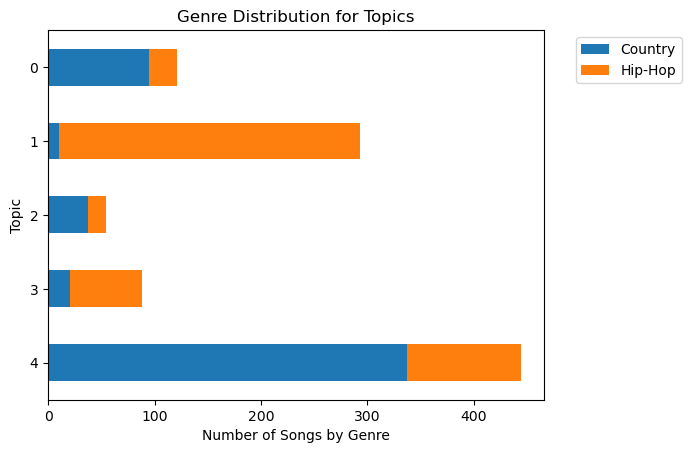

In [108]:
# Create a crosstab
crosstab = pd.crosstab(results['Dominant_Topic'], results['Genre']).sort_values(by="Dominant_Topic", ascending=False)

# Plot the crosstab
crosstab.plot(kind='barh', stacked=True).legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Number of Songs by Genre')
plt.ylabel('Topic')
plt.title('Genre Distribution for Topics')
plt.show()

#### Visualization (PCA) (visualizing LDA Results)

In [109]:
results

,Genre,Lyrics,0,1,2,3,4,Dominant_Topic
0,Country,i wanna wake where i was born and breathe the ...,0.000000,0.000000,0.000000,0.000000,0.987989,4
1,Country,now this is a story about the young man from n...,0.656430,0.270923,0.000000,0.000000,0.067781,0
2,Country,stinking up the curb lane baby in the middle o...,0.000000,0.000000,0.000000,0.990660,0.000000,3
3,Country,a jukebox introduced us when the sixties were ...,0.206459,0.000000,0.000000,0.000000,0.779286,4
4,Country,(i do swear that i'll always be there i'd give...,0.000000,0.000000,0.000000,0.205204,0.783936,4
...,...,...,...,...,...,...,...,...
995,Hip-Hop,it was just one of those days* me the joker an...,0.871082,0.000000,0.000000,0.000000,0.117262,0
996,Hip-Hop,haha you ready bow yeah {lets go then} yeah ye...,0.000000,0.669741,0.326324,0.000000,0.000000,1
997,Hip-Hop,[intro] yo check it out it's fucked up and i d...,0.000000,0.520297,0.000000,0.238135,0.239241,1
998,Hip-Hop,i wanted to do right but i wanted the dream wa...,0.000000,0.000000,0.151531,0.000000,0.840770,4


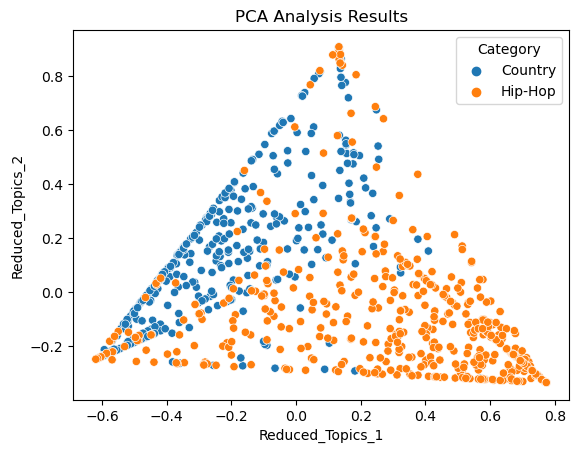

In [111]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(results[[i for i in range(0, num_topics)]])
results[['Reduced_Topics_1', 'Reduced_Topics_2']] = reduced
#Scatter Plot
sns.scatterplot(x='Reduced_Topics_1', y='Reduced_Topics_2', hue='Genre', data=results)
plt.title('PCA Analysis Results')
plt.legend(title='Category')
plt.show()

### Using Clustering

In [112]:
kmeans = KMeans(n_clusters=num_genres, random_state=0).fit(results[[i for i in range(0, num_topics)]])
results["Cluster"] = kmeans.labels_
results

c:\Users\anjan\anaconda3\envs\Studienarbeit\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\anjan\anaconda3\envs\Studienarbeit\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


,Genre,Lyrics,0,1,2,3,4,Dominant_Topic,Reduced_Topics_1,Reduced_Topics_2,Cluster
0,Country,i wanna wake where i was born and breathe the ...,0.000000,0.000000,0.000000,0.000000,0.987989,4,-0.614472,-0.246182,1
1,Country,now this is a story about the young man from n...,0.656430,0.270923,0.000000,0.000000,0.067781,0,0.255449,0.492120,0
2,Country,stinking up the curb lane baby in the middle o...,0.000000,0.000000,0.000000,0.990660,0.000000,3,0.244249,0.205632,0
3,Country,a jukebox introduced us when the sixties were ...,0.206459,0.000000,0.000000,0.000000,0.779286,4,-0.456720,-0.004754,1
4,Country,(i do swear that i'll always be there i'd give...,0.000000,0.000000,0.000000,0.205204,0.783936,4,-0.437053,-0.152841,1
...,...,...,...,...,...,...,...,...,...,...,...
995,Hip-Hop,it was just one of those days* me the joker an...,0.871082,0.000000,0.000000,0.000000,0.117262,0,0.043620,0.768384,0
996,Hip-Hop,haha you ready bow yeah {lets go then} yeah ye...,0.000000,0.669741,0.326324,0.000000,0.000000,1,0.576429,-0.135832,0
997,Hip-Hop,[intro] yo check it out it's fucked up and i d...,0.000000,0.520297,0.000000,0.238135,0.239241,1,0.313367,-0.186276,0
998,Hip-Hop,i wanted to do right but i wanted the dream wa...,0.000000,0.000000,0.151531,0.000000,0.840770,4,-0.497231,-0.168293,1


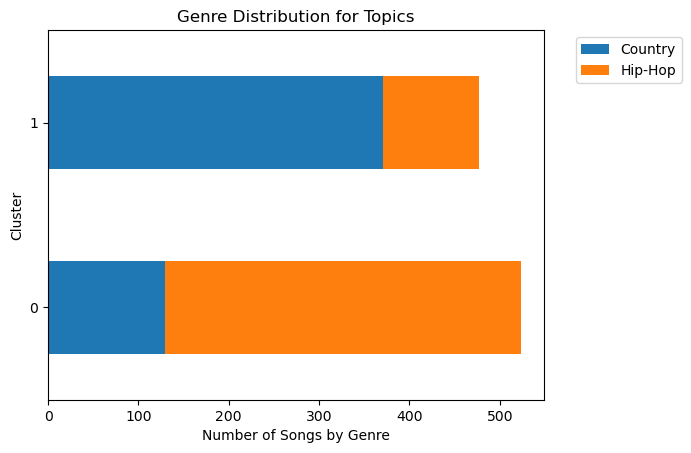

In [114]:
# Create a crosstab
crosstab = pd.crosstab(results['Cluster'], results['Genre'])

# Plot the crosstab
crosstab.plot(kind='barh', stacked=True).legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Number of Songs by Genre')
plt.ylabel('Cluster')
plt.title('Genre Distribution for Topics')
plt.show()

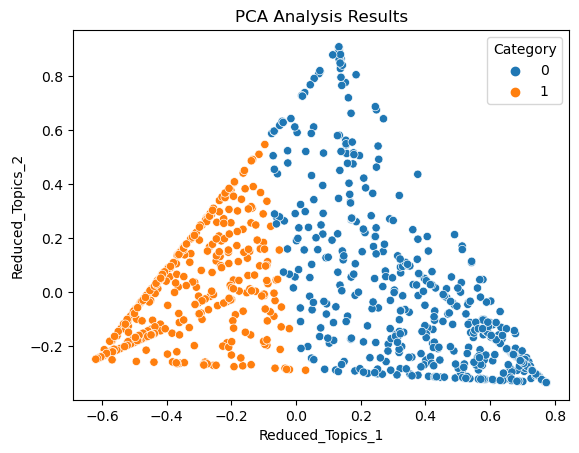

In [115]:
#Scatter Plot
sns.scatterplot(x='Reduced_Topics_1', y='Reduced_Topics_2', hue='Cluster', data=results)
plt.title('PCA Analysis Results')
plt.legend(title='Category')
plt.show()

### Trying to predict the genre based on the topic vector

In [116]:
X = results[[i for i in range(0, num_topics)]]
label_encoder = LabelEncoder()
results["GenreID"] = label_encoder.fit_transform(results["Genre"])
y = results["GenreID"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [117]:
#K-nearest neighbors
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train, y_train)
neigh.score(X_test, y_test)

0.89

In [118]:
#svm classifier
svc = SVC(kernel="linear")
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.8933333333333333

In [119]:
#Random forest
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.8766666666666667

### Get Classification Matrix (of knn)

In [120]:
y_pred = svc.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       150
           1       0.93      0.85      0.89       150

    accuracy                           0.89       300
   macro avg       0.90      0.89      0.89       300
weighted avg       0.90      0.89      0.89       300



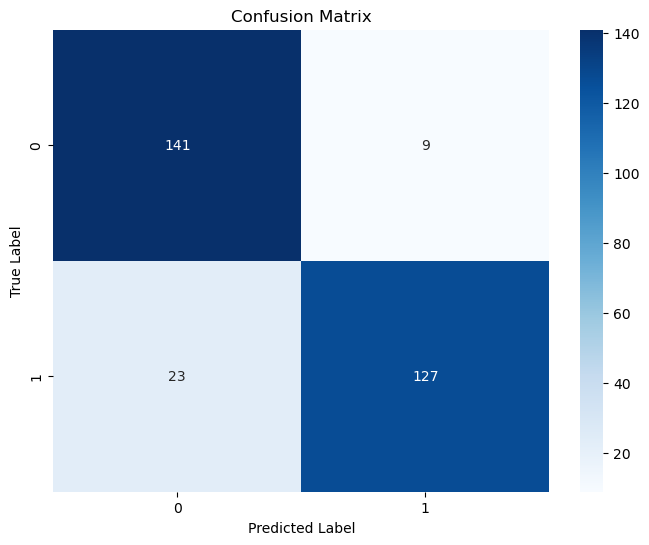

In [121]:
conf_matrix = confusion_matrix(y_test, y_pred)
# Get the class labels
class_labels = svc.classes_

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [122]:
results[["Genre", "GenreID"]].drop_duplicates()

,Genre,GenreID
0,Country,0
500,Hip-Hop,1


### Was hier gemacht wurde:
- Nehmen eines song subsets mit jeweils n songs aus den Genres HipHop und Country
- Bereinigen der Lyrics mit verschiedenen Preprocessing methoden (Best Practice)
- Using LDA to get most important topic based on all the songs
- applying the LDA topics to each song individually
- Investigating whether there is a correlation between the topics and the song genres, using crosstabs and, PCA-Scatterplots and Clustering
- Investigating whether it is possible to predict a genre based on its most prominent topics 
- Variation der Anzahl der topics um zu vergleichen was die besten ergebnisse liefert

### Ergebnis
- Starker unterschied zwischen den Themen bei HipHop und Country Songs
- Country Songs fallen kaum in die Hip-Hop Kategorie, während dies anders herum schon teilweise der Fall ist (HipHop ist also doch etwas offener im Topic)
- Starkes HipHop Topic mit vielen slang begriffen, während country category etwas freier gehalten ist (zumindest bei 2 topics)
- Ergebnisse sehr viel eindeutiger als bei der Vorherigen Lösung
- Vorhersage des Genres aus Topics extrem gut möglich, accuracy bis zu 87%
- Die Ergebnisse sind nahezu identisch bei Erhöhung der Anzahl der Topics auf 10, einzig die PCA zeigt dabei etwas visuellere Ergebnisse und auch das Clustering scheint in Ordnung zu funktionieren
- Bei 20 Topics nimmt die Qualität der Ergebnisse ab
- ca. 5 topics scheint der sweet spot zu sein, damit steigt die accuracy auf bis zu 89%
- Clustering der Ergebnisse Funktioniert nicht, dafür sind die Ergebnisse nicht eindeutig genug abgetrennt


### Interpretation
- Das Model funktioniert bereits besser als das vorherige. Die Vermutung liegt nahe, dass es zwischen manchen Genres mehr Unterschiede als zwischen anderen gibt. Ein gutes beispiel dafür ist HipHop, das sich relativ klar unterscheiden lässt.
- Es ist gut möglich anhand der Lyrics zu unterscheiden ob ein Song Hip-Hop oder Country zugeordnet werden kann